*Ensemble Learning* involves training a group of predictors (an *ensemble*) and aggregating their predictions to achieve better accuracy than any of the individual models.

Ensemble methods are typically applied near the end of a project after some effective predictors have been identified.

Topics:
- Voting Classifiers
- Bagging & Pasting
- Random Forests
- Boosting
- Stacking

# Voting Classifiers

*Voting classifiers* aggregate the predictions of different classifiers.

- *Hard voting*: each classifier makes a prediction and the class with the most votes is selected
- *Soft voting*: each classifier determines the probability of each class and the class with the highest average probability is selected

An ensemble's accuracy tends to improve when the classifiers are more independent from one another. Different algorithms are subject to different types of errors, so a diverse group is less likely to repeat the same errors and thus ensures the ensemble will be more robust.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# Demonstration using the moons dataset
X, y = make_moons(n_samples=500, noise=0.30)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

hard_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
hard_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [3]:
from sklearn.metrics import accuracy_score

def accuracies(clf_tuple):
    # Check the accuracy of each model
    for clf in clf_tuple:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"{clf.__class__.__name__}: {accuracy_score(y_test, y_pred)}")

accuracies((log_clf, rnd_clf, svm_clf, hard_voting_clf))

LogisticRegression: 0.848
RandomForestClassifier: 0.936
SVC: 0.92
VotingClassifier: 0.92


In [4]:
# Soft voting increases training time
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
soft_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [5]:
accuracies((log_clf, rnd_clf, svm_clf, soft_voting_clf))

LogisticRegression: 0.848
RandomForestClassifier: 0.936
SVC: 0.92
VotingClassifier: 0.92


# Bagging & Pasting

Another ensemble learning approach is to use the same training algorithmm for each predictor but train them on different random subsets of the training data. *Bagging* (or bootstrap aggregating) and *pasting* are two sampling methods for this approach.

- *Bagging*: sampling with replacement
- *Pasting*: sampling without replacement

Predictions are made via aggregation, typically using the statistical mode function (most frequent prediction) similar to a hard voting classifier. Each predictor will have a higher bias due to the smaller sample of training data, but the ensemble benefits from this much like it does from error diversity in voting classification, resulting in a lower overall bias and variance.

Bagging and pasting can train and predict in parallel, so they are attractive methods for scaling.

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 500 decision trees with 100 samples each, using maximum number of CPU cores
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500, 
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [7]:
y_pred = bag_clf.predict(X_test)
print(f"BaggingClassifier: {accuracy_score(y_test, y_pred)}")

BaggingClassifier: 0.92


In [8]:
# Disable bootstrap for pasting
past_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500, 
    max_samples=100,
    bootstrap=False,
    n_jobs=-1
)
past_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [9]:
y_pred = past_clf.predict(X_test)
print(f"PastingClassifier: {accuracy_score(y_test, y_pred)}")

PastingClassifier: 0.92


When using replacement (bagging), each predictor samples ~63% of the training data. The remaining ~37% is considered *out-of-bag* (oob). This data can be used to evaluate the classifier after training and predict how accurate it will be.

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500, 
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8826666666666667

In [11]:
# Compare with accuracy using the test set
accuracy_score(y_test, bag_clf.predict(X_test))

0.92

In [12]:
# Access probabilities of each classifier in the bag
bag_clf.oob_decision_function_[:5]

array([[0.9296875 , 0.0703125 ],
       [0.02688172, 0.97311828],
       [0.04145078, 0.95854922],
       [0.0078125 , 0.9921875 ],
       [0.96774194, 0.03225806]])

Predictors can also be trained on a random subset of the input features.

- *Random Patches*: sampling both instances and features
- *Random Subspaces*: keeping all instances and sampling only features

In [13]:
# Random patches
bag_clf_patch = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500, 
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
    bootstrap_features=True,
    max_features=0.5
)
bag_clf_patch.fit(X_train, y_train)
bag_clf_patch.oob_score_

0.832

In [14]:
accuracy_score(y_test, bag_clf_patch.predict(X_test))

0.912

In [15]:
# Random subspaces
bag_clf_sub = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500, 
    max_samples=1.0,
    bootstrap=False,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.5
)
bag_clf_sub.fit(X_train, y_train)
accuracy_score(y_test, bag_clf_sub.predict(X_test))

0.816

Random patches and subspaces are mostly useful when handling high-dimensional inputs such as images.

# Random Forests

A *Random Forest* is an ensemble of decision trees typically trained via bagging with max samples hyperparameter set to the size of the training set.

The RandomForestClassifier is an optimized alternative to creating a BaggingClassifier with DecisionTreeClassifier.

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [17]:
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

Random Forests can be made even more random by using random feature thresholds when growing trees instead of searching for the best possible thresholds. These trees are called *Extremely Randomized Trees*, or *Extra-Trees*.

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
et_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=16, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [19]:
y_pred_et = et_clf.predict(X_test)
accuracy_score(y_test, y_pred_et)

0.912

Random Forests are useful for measuring feature importance by observing how nodes using each feature reduce impurity across all trees in the forest.

In [20]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [21]:
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(f'{name}: {score}')

sepal length (cm): 0.10151932208052032
sepal width (cm): 0.024460788827573698
petal length (cm): 0.4205219978980827
petal width (cm): 0.45349789119382317


# Boosting

*Boosting* refers to the method of combining several weak learners into a strong learner, usually trained sequentially. *AdaBoost* (or *Adaptive Boosting*) and *Gradient Boosting* are two very common methods.

Since training is done sequentially, this method can't be parallelized and therefore doesn't scale as well as bagging or pasting.

## AdaBoost

The *AdaBoost* method start by training a base classifier, increases the weights for misclassified instances, and trains another classifier with the updated weights. This process is repeated for all predictors in the ensemble, and predictions are made via aggregation as with bagging or pasting with weights assigned according to the accuracy of the predictor.

Step 1: Determine the error rate of a predictor

*Equation 1: Weighted error rate of the $j^{th}$ predictor*

\begin{equation*}
r_j = \frac{
    \sum_{\substack{
        \hat{y}_j^{(i)}
        \neq
        y^{(i)}
    \\i=1}}^m w^{(i)}
}{
    \sum_{i=1}^m w^{(i)}
}
\end{equation*}

- $\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance.

Step 2: Determine the predictor's weight

*Equation 2: Predictor weight*

\begin{equation*}
\alpha_j = \eta \text{log} \frac{1-r_j}{r_j}
\end{equation*}

- $\eta$ is the learning rate
- $\alpha_j \gt 0$ when the predictor is $\gt 50$% accurate
- $\alpha_j \lt 0$ when the predictor is $\lt 50$% accurate
- $\alpha_j \approx 0$ when the predictor is $\approx 50$% accurate

Step 3: Boost misclassified instance weights

*Equation 3: Weight update rule*

\begin{equation*}
\text{for } i=1, 2, \cdots, m\\
w^{(i)} \leftarrow
    \begin{cases}
    & w^{(i)} & \text{ if } \hat{y}_j^{(i)} = y^{(i)} \\
    & w^{(i)} \text{exp}\bigl(\alpha_j\bigr) & \text{ if } \hat{y}_j^{(i)} \neq y^{(i)} \\
    \end{cases}
\end{equation*}

- The weights are then normalized by dividing by $\sum_{i=1}^m w^{(i)}$

Steps 1-3 are repeated until all predictors have been trained or a perfect predictor is established.

*Equation 4: AdaBoost predictions*

\begin{equation*}
\hat{y}(\mathbf{x}) = \underset{k}{\text{argmax}} \sum_{\substack{\hat{y}_j(\mathbf{x})=k\\j=1}}^N \alpha_j
\end{equation*}

- $N$ is the number of predictors

In [22]:
from sklearn.ensemble import AdaBoostClassifier

# Use 200 decision stumps and the SAMME.R algorithm
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [23]:
accuracy_score(y_test, ada_clf.predict(X_test))

0.912

In [24]:
# A regression variant also exists
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1),
    n_estimators=200,
    learning_rate=0.5
)
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

In [25]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, ada_reg.predict(X_test))

0.13333293368222843

## Gradient Boosting

*Gradient Boosting* operates similarly to AdaBoost in that it trains predictors sequentially, but rather than adjusting instance weights it fits each predictor following the first to residual errors made by the previous iteration.

In [27]:
import numpy as np

# Random quadratic data with noise
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [28]:
# First predictor, standard decision tree regressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

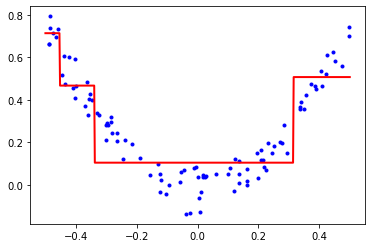

In [52]:
import matplotlib.pyplot as plt

def plot_regs(regs):
    x1 = np.linspace(-0.5, 0.5, 500)
    y_pred = sum(reg.predict(x1.reshape(-1, 1)) for reg in regs)
    plt.plot(X, y, 'b.')
    plt.plot(x1, y_pred, 'r', linewidth=2)

plot_regs([tree_reg1])

In [53]:
# Determine residual errors from first predictor
y2 = y - tree_reg1.predict(X)

# Fit a new predictor to the residuals
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

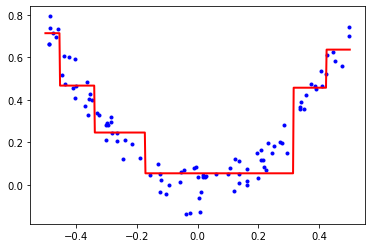

In [54]:
plot_regs([tree_reg1, tree_reg2])

In [55]:
# Repeat for a third predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

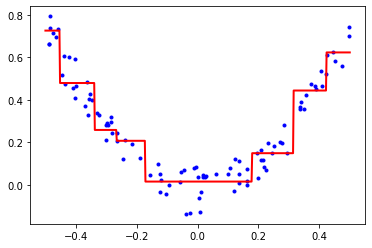

In [56]:
plot_regs([tree_reg1, tree_reg2, tree_reg3])

In [57]:
# GradientBoostingRegressor accomplishes the same thing
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

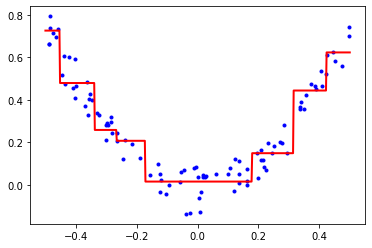

In [58]:
plot_regs([gbrt])

A regularization technique called *shrinkage* may be applied by reducing learning rate and increasing the number of trees to improve generalization.

In [59]:
gbrt_shrink = GradientBoostingRegressor(max_depth=2, n_estimators=30, learning_rate=0.1)
gbrt_shrink.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=30,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

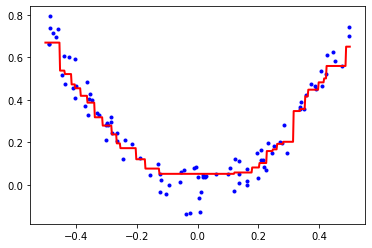

In [60]:
plot_regs([gbrt_shrink])

- Too few trees will underfit
- Too many trees will overfit

Early stopping may be used to determine an optimal number of trees for a given learning rate.

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

# Use up to 120 trees
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
# Store error for each iteration
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

Text(0, 0.5, 'Error')

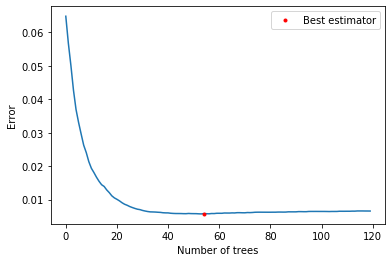

In [76]:
plt.plot(errors)
plt.plot(best_n_estimators, errors[best_n_estimators], 'r.', label='Best estimator')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Error')

In [78]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=54,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

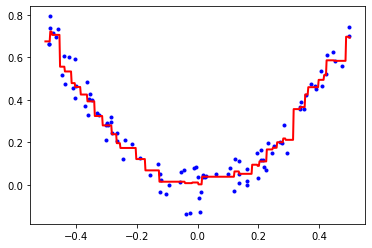

In [79]:
plot_regs([gbrt_best])

In [80]:
# Another option is to stop training once a threshold is reached
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

In [83]:
# Not as concise, but will save time on larger sets
min_val_error = np.inf
error_increasing = 0
for n in range(1, 120):
    gbrt.n_estimators = n
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_increasing = 0
    else:
        error_increasing += 1
        # Stop condition: 5 iterations with increasing error
        if error_increasing == 5:
            break

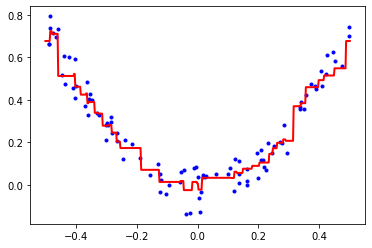

In [84]:
plot_regs([gbrt])

Subsampling may be used to employ the *Stochastic Gradient Boosting* technique, which uses only a fraction of the training set to train each tree. This technique trades higher bias for lower variance and improves training speed.

In [85]:
# Specify 25% of the training set for each tree
stoch_gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, subsample=0.25)
stoch_gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=54,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.25, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

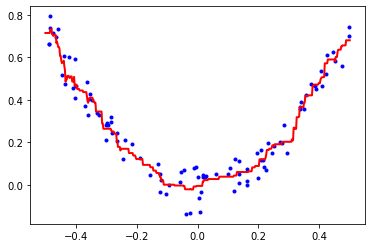

In [86]:
plot_regs([stoch_gbrt])

The XGBoost (Extreme Gradient Boosting) library is a specialized Python library specifically for optimized Gradient Boosting.

In [87]:
import xgboost

In [88]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

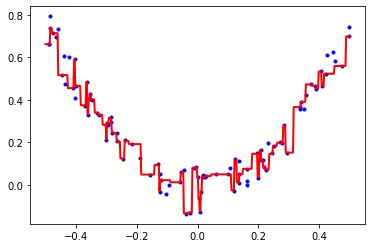

In [90]:
plot_regs([xgb_reg])

In [91]:
# XGBoost includes useful features like early stopping
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

[0]	validation_0-rmse:0.22695
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16943
[2]	validation_0-rmse:0.13137
[3]	validation_0-rmse:0.10839
[4]	validation_0-rmse:0.09442
[5]	validation_0-rmse:0.08711
[6]	validation_0-rmse:0.08427
[7]	validation_0-rmse:0.08204
[8]	validation_0-rmse:0.08225
[9]	validation_0-rmse:0.08283
Stopping. Best iteration:
[7]	validation_0-rmse:0.08204



XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

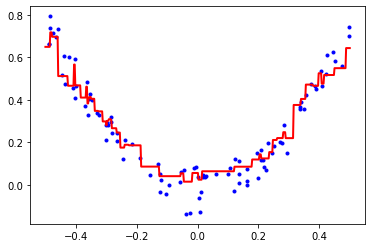

In [92]:
plot_regs([xgb_reg])

# Stacking

*Stacking*, or *stacked generalization*, trains a model to perform aggregation rather than relying on functions such as hard or soft voting.

This technique is applied by training a number of independent predictors (as with voting or bagging/pasting), and then using a *blender* predictor that takes these predictions as inputs to make a final prediction.

To train a blender, one must set aside a portion of the training data (referred to as a *hold-out set*) before training the initial predictors, then training the blender on the predictions generated on the hold-out set by the predictors. 

In [103]:
from deslib.des.knora_e import KNORAE

X, y = make_moons(n_samples=500, noise=0.30)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)

# Train a pool of 10 classifiers
stack_reg = RandomForestClassifier(n_estimators=10)
stack_reg.fit(X_train, y_train)

# Initialize the DES model
knorae = KNORAE(stack_reg)

# Preprocess the Dynamic Selection dataset (DSEL)
knorae.fit(X_dsel, y_dsel)

# Predict new examples:
y_pred = knorae.predict(X_test)

knorae.score(X_test, y_test)

0.816